In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
from bart_playground import *
import bartz
from stochtree import BARTModel
import time

## Abalone Data

In [2]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
abalone = fetch_ucirepo(id=1) 
  
# data (as pandas dataframes) 
X = abalone.data.features 
y = abalone.data.targets 

# variable information 
print(abalone.variables)

             name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7        

In [3]:
if 'Sex' in X.columns:
    print("\nSex value counts:")
    print(X['Sex'].value_counts())


Sex value counts:
Sex
M    1528
I    1342
F    1307
Name: count, dtype: int64


In [4]:
X = X.drop(columns=['Sex'])
X

,Length,Diameter,Height,Whole_weight,Shucked_weight,Viscera_weight,Shell_weight
0,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.1500
1,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.0700
2,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.2100
3,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.1550
4,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.0550
...,...,...,...,...,...,...,...
4172,0.565,0.450,0.165,0.8870,0.3700,0.2390,0.2490
4173,0.590,0.440,0.135,0.9660,0.4390,0.2145,0.2605
4174,0.600,0.475,0.205,1.1760,0.5255,0.2875,0.3080
4175,0.625,0.485,0.150,1.0945,0.5310,0.2610,0.2960


In [5]:
X = X.values.astype(float)
y = np.array(y).reshape(-1)

In [6]:
test_mse_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto", "rf", "xgb", "lr"]}
train_mse_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto", "rf", "xgb", "lr"]}
pi_length_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto"]}
coverage_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto"]}
time_results = {name: [] for name in ["bart_ntrees", "bart_default", "btz", "sto", "rf", "xgb", "lr"]}
n_trees_results = []

In [7]:
n_runs = 10
n_post = 100

n_trees_ini = 100
special_probs = {"birth": 0.25, "death": 0.25, "break": 0.25, "combine": 0.25}
for seed in range(n_runs):
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=seed)
    
    # bart with ChangeNumTreeBART
    t0 = time.time()
    bart_n = ChangeNumTreeBART(ndpost=n_post, nskip=3000, n_trees=n_trees_ini, special_probs = special_probs, 
                               theta_0_ini = n_trees_ini, theta_0_min = 2, theta_0_nskip_prop=0.5,
                               tree_num_prior_type="com_poisson", max_com_nu=5.0, gp_eta_nskip_prop=0.3,
                               special_move_interval=5)
    bart_n.fit(X_train, y_train)
    time_results["bart_ntrees"].append(time.time() - t0)

    # Use the final number of trees from the trace for the other models
    n_trees = bart_n.trace[-1].n_trees
    n_trees_results.append(n_trees)
    n_skip = 500 # Shoule be enough for the other bart models to converge

    # bart with DefaultBART
    t0 = time.time()
    bart = DefaultBART(ndpost=n_post, nskip=n_skip, n_trees=n_trees)
    bart.fit(X_train, y_train)
    time_results["bart_default"].append(time.time() - t0)
    
    # btz
    t0 = time.time()
    btz = bartz.BART.gbart(np.transpose(X_train), y_train, ntree=n_trees, ndpost=n_post, nskip=n_skip, printevery=200)
    btpred_all_test = btz.predict(np.transpose(X_test))
    btpred_all_test = np.array(btpred_all_test)
    btpred_test = np.mean(btpred_all_test, axis=0)
    btpred_all_train = btz.predict(np.transpose(X_train))
    btpred_train = np.mean(np.array(btpred_all_train), axis=0)
    time_results["btz"].append(time.time() - t0)
    
    # sto
    t0 = time.time()
    sto = BARTModel()
    # use a variance forest to enable variance estimation
    sto.sample(X_train=X_train, y_train=y_train,
               num_gfr=0, num_burnin=n_skip, num_mcmc=n_post, 
               mean_forest_params={"num_trees": n_trees}, variance_forest_params={"num_trees": n_trees // 2})
    sto_pred_all_test, sto_all_sigma = sto.predict(X_test)
    sto_pred_test = np.mean(sto_pred_all_test, axis=1)
    sto_pred_train = np.mean(sto.predict(X_train)[0], axis=1)
    time_results["sto"].append(time.time() - t0)

    # rf
    t0 = time.time()
    rf = RandomForestRegressor(n_estimators=n_trees, random_state=seed)
    rf.fit(X_train, y_train)
    time_results["rf"].append(time.time() - t0)

    # xgb
    t0 = time.time()
    xgbr = xgb.XGBRegressor(n_estimators=n_trees, random_state=seed, verbosity=0)
    xgbr.fit(X_train, y_train)
    time_results["xgb"].append(time.time() - t0)

    # lr
    t0 = time.time()
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    time_results["lr"].append(time.time() - t0)
    
    # Test MSE
    test_mse_results["bart_ntrees"].append(mean_squared_error(y_test, bart_n.predict(X_test)))
    test_mse_results["bart_default"].append(mean_squared_error(y_test, bart.predict(X_test)))
    test_mse_results["btz"].append(mean_squared_error(y_test, btpred_test))
    test_mse_results["sto"].append(mean_squared_error(y_test, sto_pred_test))
    test_mse_results["rf"].append(mean_squared_error(y_test, rf.predict(X_test)))
    test_mse_results["xgb"].append(mean_squared_error(y_test, xgbr.predict(X_test)))
    test_mse_results["lr"].append(mean_squared_error(y_test, lr.predict(X_test)))

    # Train MSE
    train_mse_results["bart_ntrees"].append(mean_squared_error(y_train, bart_n.predict(X_train)))
    train_mse_results["bart_default"].append(mean_squared_error(y_train, bart.predict(X_train)))
    train_mse_results["btz"].append(mean_squared_error(y_train, btpred_train))
    train_mse_results["sto"].append(mean_squared_error(y_train, sto_pred_train))
    train_mse_results["rf"].append(mean_squared_error(y_train, rf.predict(X_train)))
    train_mse_results["xgb"].append(mean_squared_error(y_train, xgbr.predict(X_train)))
    train_mse_results["lr"].append(mean_squared_error(y_train, lr.predict(X_train)))

    # Prediction intervals
    # btz: axis=0, shape (n_mcmc, n_test)
    eps = np.zeros_like(btpred_all_test)
    for i in range(n_post):
        eps[i] = np.random.normal(0, btz.sigma[i], size=btpred_all_test.shape[1])
        btpred_all_test[i, :] += eps[i]    
    btz_lower = np.percentile(btpred_all_test, 2.5, axis=0)
    btz_upper = np.percentile(btpred_all_test, 97.5, axis=0)
    pi_length_results["btz"].append(np.mean(btz_upper - btz_lower))
    btz_covered = ((y_test >= btz_lower) & (y_test <= btz_upper)).mean()
    coverage_results["btz"].append(btz_covered)
    
    # sto: axis=1, shape (n_test, n_mcmc)
    sto_eps = np.zeros_like(sto_pred_all_test)
    for i in range(n_post):
        sto_eps[:, i] = np.random.normal(np.zeros(sto_pred_all_test.shape[0]), sto_all_sigma[:, i])
        sto_pred_all_test[:, i] += sto_eps[:, i]
    sto_lower = np.percentile(sto_pred_all_test, 2.5, axis=1)
    sto_upper = np.percentile(sto_pred_all_test, 97.5, axis=1)
    pi_length_results["sto"].append(np.mean(sto_upper - sto_lower))
    sto_covered = ((y_test >= sto_lower) & (y_test <= sto_upper)).mean()
    coverage_results["sto"].append(sto_covered)
    
    # bart_ntrees: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart_n.posterior_predict(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart_ntrees"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart_ntrees"].append(bart_covered)

    # bart_default: axis=1, shape (n_test, n_mcmc)
    bart_pred_all_test = bart.posterior_predict(X_test)
    bart_lower = np.percentile(bart_pred_all_test, 2.5, axis=1)
    bart_upper = np.percentile(bart_pred_all_test, 97.5, axis=1)
    pi_length_results["bart_default"].append(np.mean(bart_upper - bart_lower))
    bart_covered = ((y_test >= bart_lower) & (y_test <= bart_upper)).mean()
    coverage_results["bart_default"].append(bart_covered)

Iterations: 100%|██████████| 600/600 [00:09<00:00, 65.85it/s]
INFO:2025-06-26 11:59:11,246:jax._src.xla_bridge:927: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:jax._src.xla_bridge:Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO:2025-06-26 11:59:11,250:jax._src.xla_bridge:927: Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
INFO:jax._src.xla_bridge:Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.


Iteration 200/600 P_grow=0.44 P_prune=0.56 A_grow=0.25 A_prune=0.00 (burnin)
Iteration 400/600 P_grow=0.78 P_prune=0.22 A_grow=0.00 A_prune=0.00 (burnin)
Iteration 600/600 P_grow=0.44 P_prune=0.56 A_grow=0.25 A_prune=0.20


Iterations: 100%|██████████| 600/600 [00:09<00:00, 65.97it/s] 


Iteration 200/600 P_grow=0.45 P_prune=0.55 A_grow=0.00 A_prune=0.17 (burnin)
Iteration 400/600 P_grow=0.45 P_prune=0.55 A_grow=0.00 A_prune=0.00 (burnin)
Iteration 600/600 P_grow=0.73 P_prune=0.27 A_grow=0.00 A_prune=0.33


Iterations: 100%|██████████| 600/600 [00:09<00:00, 62.03it/s]


Iteration 200/600 P_grow=0.33 P_prune=0.67 A_grow=0.00 A_prune=0.00 (burnin)
Iteration 400/600 P_grow=0.67 P_prune=0.33 A_grow=0.12 A_prune=0.00 (burnin)
Iteration 600/600 P_grow=0.67 P_prune=0.33 A_grow=0.00 A_prune=0.00


Iterations: 100%|██████████| 600/600 [00:09<00:00, 62.90it/s]


Iteration 200/600 P_grow=0.56 P_prune=0.44 A_grow=0.11 A_prune=0.00 (burnin)
Iteration 400/600 P_grow=0.44 P_prune=0.56 A_grow=0.14 A_prune=0.00 (burnin)
Iteration 600/600 P_grow=0.38 P_prune=0.62 A_grow=0.17 A_prune=0.20


Iterations: 100%|██████████| 600/600 [00:12<00:00, 48.43it/s]


Iteration 200/600 P_grow=0.57 P_prune=0.43 A_grow=0.12 A_prune=0.00 (burnin)
Iteration 400/600 P_grow=0.36 P_prune=0.64 A_grow=0.40 A_prune=0.00 (burnin)
Iteration 600/600 P_grow=0.64 P_prune=0.36 A_grow=0.11 A_prune=0.00


Iterations: 100%|██████████| 600/600 [00:10<00:00, 56.81it/s]


Iteration 200/600 P_grow=0.57 P_prune=0.43 A_grow=0.12 A_prune=0.17 (burnin)
Iteration 400/600 P_grow=0.29 P_prune=0.71 A_grow=0.00 A_prune=0.10 (burnin)
Iteration 600/600 P_grow=0.64 P_prune=0.36 A_grow=0.11 A_prune=0.20


Iterations: 100%|██████████| 600/600 [00:11<00:00, 52.75it/s]


Iteration 200/600 P_grow=0.31 P_prune=0.69 A_grow=0.25 A_prune=0.11 (burnin)
Iteration 400/600 P_grow=0.69 P_prune=0.31 A_grow=0.11 A_prune=0.00 (burnin)
Iteration 600/600 P_grow=0.46 P_prune=0.54 A_grow=0.00 A_prune=0.00


Iterations: 100%|██████████| 600/600 [00:09<00:00, 62.80it/s]


Iteration 200/600 P_grow=0.42 P_prune=0.58 A_grow=0.00 A_prune=0.00 (burnin)
Iteration 400/600 P_grow=0.67 P_prune=0.33 A_grow=0.12 A_prune=0.00 (burnin)
Iteration 600/600 P_grow=0.67 P_prune=0.33 A_grow=0.00 A_prune=0.00


Iterations: 100%|██████████| 600/600 [00:10<00:00, 56.39it/s]


Iteration 200/600 P_grow=0.57 P_prune=0.43 A_grow=0.12 A_prune=0.33 (burnin)
Iteration 400/600 P_grow=0.36 P_prune=0.64 A_grow=0.20 A_prune=0.00 (burnin)
Iteration 600/600 P_grow=0.64 P_prune=0.36 A_grow=0.11 A_prune=0.20


Iterations: 100%|██████████| 600/600 [00:08<00:00, 71.59it/s]


Iteration 200/600 P_grow=0.45 P_prune=0.55 A_grow=0.00 A_prune=0.00 (burnin)
Iteration 400/600 P_grow=0.45 P_prune=0.55 A_grow=0.00 A_prune=0.00 (burnin)
Iteration 600/600 P_grow=0.82 P_prune=0.18 A_grow=0.00 A_prune=0.00


In [8]:
import pandas as pd

test_mse_df = pd.DataFrame(test_mse_results)
train_mse_df = pd.DataFrame(train_mse_results)
pi_length_df = pd.DataFrame(pi_length_results)
coverage_df = pd.DataFrame(coverage_results)
time_df = pd.DataFrame(time_results)

print(f"Test MSE ({n_runs} runs):")
print(f"Train MSE ({n_runs} runs):")
print("Test MSE Mean:")
print(test_mse_df.mean())
print("Train MSE Mean:")
print(train_mse_df.mean())

print(f"Prediction Interval Mean Length ({n_runs} runs):")
print(f"Prediction Interval Mean Length (Mean over {n_runs} runs):")
print(pi_length_df.mean())

print(f"Prediction Interval Coverage Mean ({n_runs} runs):")
print(coverage_df.mean())

print(f"Average Training Time (seconds) over {n_runs} runs:")
print(time_df.mean())

Test MSE (10 runs):
Train MSE (10 runs):
Test MSE Mean:
bart_ntrees     5.341846
bart_default    5.283023
btz             5.273231
sto             5.298103
rf              5.257365
xgb             5.000325
lr              5.072859
dtype: float64
Train MSE Mean:
bart_ntrees     4.080484
bart_default    4.343295
btz             4.567094
sto             4.792836
rf              0.873557
xgb             2.696661
lr              4.869678
dtype: float64
Prediction Interval Mean Length (10 runs):
Prediction Interval Mean Length (Mean over 10 runs):
bart_ntrees     7.738498
bart_default    8.017771
btz             8.166255
sto             7.812342
dtype: float64
Prediction Interval Coverage Mean (10 runs):
bart_ntrees     0.912057
bart_default    0.918373
btz             0.923349
sto             0.919043
dtype: float64
Average Training Time (seconds) over 10 runs:
bart_ntrees     185.457032
bart_default     10.038716
btz               7.148657
sto               1.575603
rf                0.208

In [9]:
print(f"Number of Trees (after shrinkage) in {n_runs} runs: {n_trees_results}")

Number of Trees (after shrinkage) in 10 runs: [9, 11, 12, 16, 14, 14, 13, 12, 14, 11]


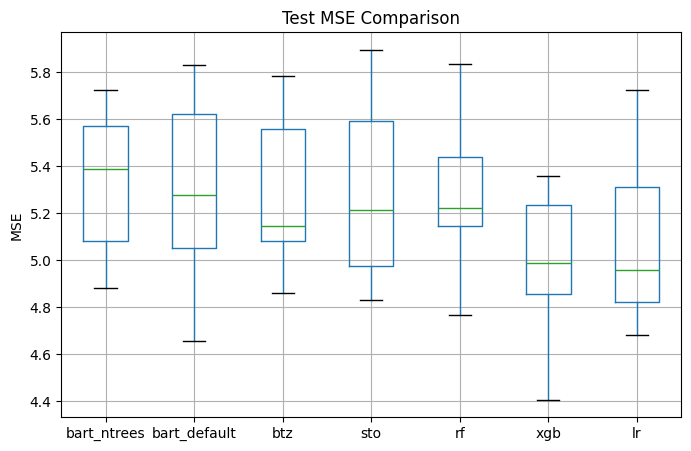

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
test_mse_df.boxplot()
plt.title("Test MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

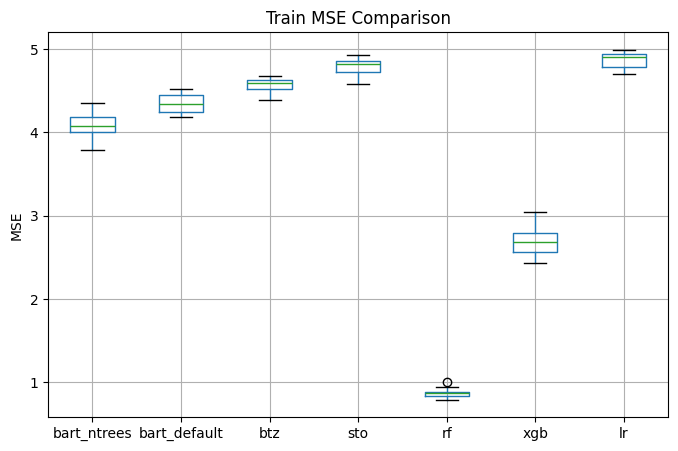

In [11]:
plt.figure(figsize=(8, 5))
train_mse_df.boxplot()
plt.title("Train MSE Comparison")
plt.ylabel("MSE")
plt.grid(True, axis='y')
plt.show()

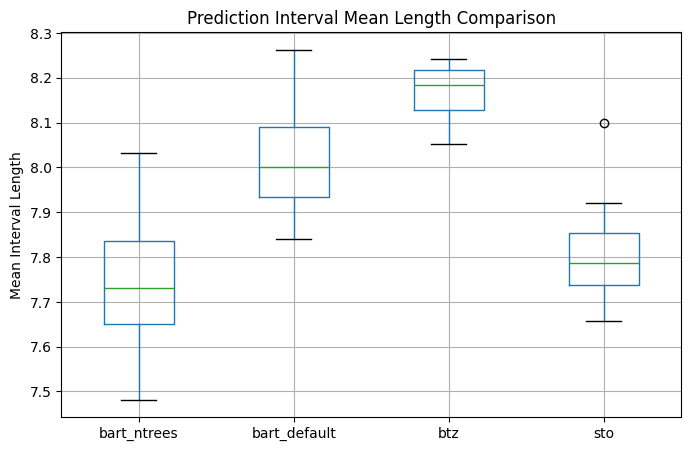

In [12]:
plt.figure(figsize=(8, 5))
pi_length_df.boxplot()
plt.title("Prediction Interval Mean Length Comparison")
plt.ylabel("Mean Interval Length")
plt.grid(True, axis='y')
plt.show()

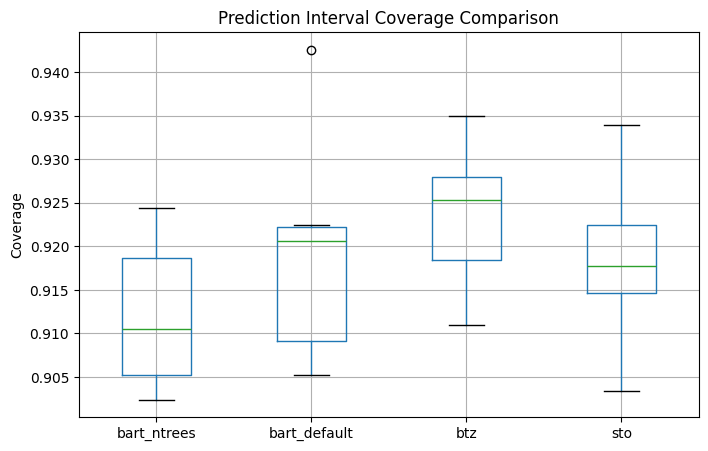

In [13]:
plt.figure(figsize=(8, 5))
coverage_df.boxplot()
plt.title("Prediction Interval Coverage Comparison")
plt.ylabel("Coverage")
plt.grid(True, axis='y')
plt.show()

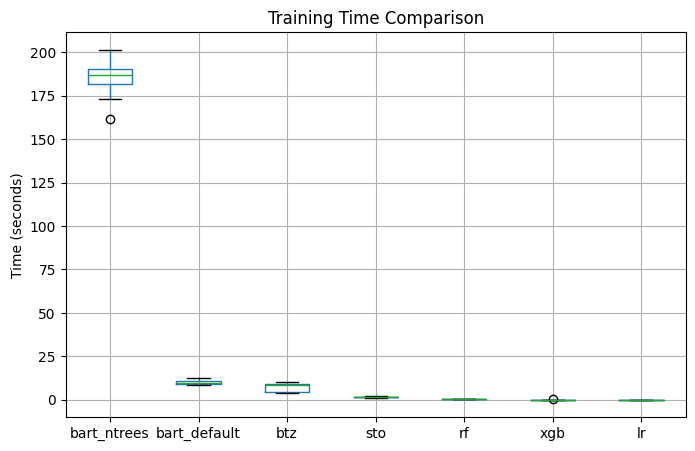

In [14]:
plt.figure(figsize=(8, 5))
time_df.boxplot()
plt.title("Training Time Comparison")
plt.ylabel("Time (seconds)")
plt.grid(True, axis='y')
plt.show()